Vision-Language Model Training on Sentinel-2 Imagery
====================================================

This tutorial constructs a training dataset from a [Planetary Computer](https://planetarycomputer.microsoft.com/) data collection and then fine-tunes Microsoft's [Florence-2 Vision-Language Model](https://huggingface.co/microsoft/Florence-2-base-ft) on that dataset. In this notebook we'll:
- Generate a physically uniform distribution of `n` coordinates
- Collect labels for the geographic regions using [OpenStreetMap](https://www.openstreetmap.org/)
- Collect and download images from the Planetary Computer's [STAC API](https://github.com/radiantearth/stac-api-spec)
- Generate natural-language captions using Azure OpenAI
- Fine-tune a Vision-Language Model on the generated dataset

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques in this notebook can be applied (with minor modifications) to other remote-sensing datasets.

Getting Started
==================

You will need to download the `map.json` file from the [PlanetaryComputerExamples GitHub repository](https://github.com/microsoft/PlanetaryComputerExamples) under `tutorials/assets/map.json` as a prerequisite to running the code cells in this notebook. It is a file that contains Polygons representing the land areas on Earth for our point sampling. You may edit this file to only include areas you wish to sample from either to match the geographic availability of the dataset or to create more specialized models. 

Below are all the packages that you will need to run this notebook. 

In [ ]:
# Imports
import os
import json
import shapely
from shapely.ops import transform
from shapely.geometry import MultiPolygon, Polygon, LineString, box
import matplotlib.pyplot as plt
import math
import random
import pandas
import csv
import folium
import overpass
import overpy
import pystac_client
import planetary_computer
import geopandas
import dask_geopandas
import pyproj
import rasterio
import rasterio.mask
import ast

# Modules for step IV. Florence-2 training 
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AdamW, get_scheduler
from PIL import Image 
# Dependencies
import numpy
import flash_attn
import einops
import timm

In [3]:
# The following packages are optional if you wish to skip part 2 of step III. Caption Generation
from openai import AzureOpenAI  
from azure.identity import DefaultAzureCredential 

Below, we set the parameters of how many data points to generate, and where to save the data. `n` is how many data points we create. `d` is the square grid side length in degrees. `DATA_DIR` specifies the master data directory. After each step in the process, we save the collected data into intermediate `.csv` files. This step becomes necessary as the number of samples `n` increases.

In [4]:
# Set Hyperparameters 
n = 100 # number of areas to randomly sample
DATA_DIR = "data/tutorial_data/" # Set the directory for the data
d = 0.05 # degree measurement size

NPARTITIONS = int(n / 50)
# Set dataset filepaths
LAND_MAP = "map.json" # Set the directory for the Polygons of the the land masses we are interested in sampling from
GRIDS = DATA_DIR + "grids.csv" # Directory to store the .csv file of randomly sampled grids
GRIDS_TAGS = DATA_DIR + "grids_tags.csv" # Store the query .json file path in .csv
GRIDS_TAGS_IMAGES = DATA_DIR + "grids_tags_images.csv" # Store the collected tags and additional STAC Item metadata
IMAGES_TAGS = DATA_DIR + "images_tags.csv" # Store the collected images and tag lists as pairs in .csv
IMAGES_CAPTIONS = DATA_DIR + "images_captions.csv" # Store the generated captions for the images in .csv
IMAGES_DIR = DATA_DIR + "images/" # Directory for cropped images
MODEL_DIR = DATA_DIR + "model/" # Directory for the model files

print(f"Master data directory: {DATA_DIR}")
print(f"Generate {n} grids with size {d} x {d}")

Master data directory: data/tutorial_data/
Generate 100 grids with size 0.05 x 0.05


Make the directories if they do not already exist.

In [4]:
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Directories {DATA_DIR}, {IMAGES_DIR}, and {MODEL_DIR} created")

Directories data/tutorial_data/, data/tutorial_data/images/, and data/tutorial_data/model/ created


I. Object Collection
====================

This section uses the OverPass API to query OpenStreetMap (OSM). We randomly select geographic regions all over the world and from these regions, collect all of the OSM tags associated within the bounding box of the grid. The objects selected are stored in a `.csv` file for reference by future code blocks.

### 1. Generating the Grids


Randomly select `n` (ex. 100) grids across the globe, each with size `d`° x `d`° (ex. 0.05°).

To sample data from land areas only, we supply a GeoJson file `map.json` as a collection of polygons representing land masses on Earth. It is a somewhat rough estimate, but for our purposes it allows us to sample images that contain the features we are interested in (land formations and vegetation). Feel free to edit the `map.json` file to only include areas you wish to sample from! Here we plot these polygons for visualization:

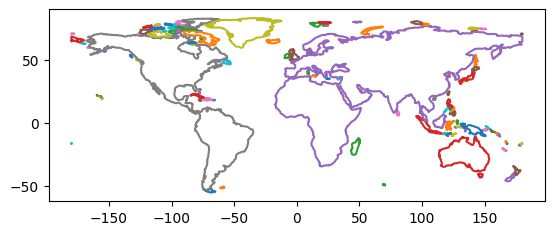

In [5]:
# Load GeoJSON of land polygons
with open(LAND_MAP) as file:
    land = json.load(file)

# Create a MultiPolygon from the land geometries by extracting the coordinates
ob = MultiPolygon([Polygon((feature["coordinates"])[0]) for feature in land["geometries"]])

# Plot Multipolygon
fig, ax = plt.subplots()
ax.set_aspect('equal')
for polygon in ob.geoms:
    x, y = polygon.exterior.xy
    ax.plot(x, y)
plt.show()

For our random sampling process, we will use Gaussian-distributed random vectors normalized to the unit sphere for a physically uniform sampling of locations. 

In [6]:
def generate_random_coordinate() -> tuple[float, float]:
    """
    This function generates a random coordinate on the Earth's surface using a uniform normal distribution on the unit sphere. 

    Returns:
        (longitude, latitude): A tuple of the longitude and latitude coordinates of the generated coordinate, in this order.

    """
    gx = random.gauss(0.0, 1.0)
    gy = random.gauss(0.0, 1.0)
    gz = random.gauss(0.0, 1.0)

    norm2 = gx**2 + gy**2 + gz**2
    norm1 = 1.0 / math.sqrt(norm2)

    x = gx * norm1
    y = gy * norm1
    z = gz * norm1

    radLat = math.asin(z)
    radLon = math.atan2(y, x)

    lat = math.degrees(radLat)
    lon = math.degrees(radLon)

    return lon, lat

print("Function generate_random_coordinate defined!")

Function generate_random_coordinate defined!


*Some important values*
- 1 degree of latitude = 69 miles
- 1 degree of longitude at equator = 69.172 miles 
- 1 degree of longitude = cosine (latitude in radians) * length of degree (miles) at equator 

In [7]:
LONGITUDE = 69.172 # 1 degree of longitude is approximately 69.172 miles at the equator
LATITUDE = 69 # 1 degree of latitude is approximately 69 miles

Now that we have the points as the centers for our bounding boxes, we are ready to create the boxes. Latitude lines are very evenly separated at approximately 69 miles no matter your longitude. Yet, longitude lines are the furthest apart at the equator at ~69.172 miles and eventually approach 0 miles apart as you approach the poles. This means that we cannot simply add and subtract `d/2` degrees to each coordinate. We need to account for this ratio of longitude separation according to the latitude. So our grids are standardized by the longitude and latitude of degrees `d` at the *equator* so ~ `d` * 69mi x `d` * 69mi sized grids.

To avoid the hassle of splitting a grid into two geometries for crossing the latitude or longitude degree boundaries, we remove this possibility.

In [8]:
def not_crossing_antimeridian(lon : float, lat : float, distance : float) -> bool:
    """
    This function ensures that the generated coordinate would not cross the antimeridian when a square of a given distance is centered at the (lon, lat) coordinate.

    Args:
        lon: float representing the decimal longitude of the coordinate you wish to check
        lat: float representing the decimal latitude of the coordinate you wish to check

    Returns:
        bool: True if the generated coordinate would not cross the antimeridian, False otherwise.

    """
    distance = distance/2 # distance is the length of the side of the square, so we need to divide by 2 to get the distance from the center to the edge
    distance = distance * LONGITUDE # Grid dimensions in miles

    # convert latitude to radians
    lat_rad = math.radians(lat)
    long_degree = math.cos(lat_rad) * LONGITUDE
    longitude = distance / long_degree
    latitude = distance / LATITUDE

    minX = lon - longitude
    minY = lat - latitude
    maxX = lon + longitude
    maxY = lat + latitude
    
    if (minX < -180) or (minY < -90) or (maxX > 180) or (maxY > 90): # Goes out of bounds
        return False
    return True

print("Function not_crossing_antimeridian defined!")

Function not_crossing_antimeridian defined!


This function generates random coordinates and checks to see if the coordinate is in the bounds of the `map.json` Polygons. This continues until we have `n` valid points.

In [9]:
def random_points_in_bounds(n : int) -> list[tuple[float, float]]:  
    """
    This function generates n random coordinates located in the land boundaries of Earth's surface. 

    Args: 
        n: The number of random coordinates to generate.

    Returns:
        A list of tuples of the longitude and latitude coordinates of the generated coordinates.

    """
    # Load GeoJSON of land polygons
    with open(LAND_MAP) as file:
        land = json.load(file)

    # Create a MultiPolygon from the land geometries by extracting the coordinates
    land_areas = MultiPolygon([Polygon((feature["coordinates"])[0]) for feature in land["geometries"]])
    points = []

    # Continuously generate a random coordinate and check if it is in the MultiPolygon
    while (len(points) < n):
        point = generate_random_coordinate()
        
        valid = False
        valid = shapely.contains_xy(land_areas, point[0], point[1]) and not_crossing_antimeridian(point[0], point[1], d)
        if valid:
            points.append(point)
            
    return points

print("Function random_points_in_bounds defined!")

Function random_points_in_bounds defined!


In [10]:
def create_bbox(lon : float, lat : float, distance : float) -> list[float]:
    """
    This function generates a square bounding box of degree d x d (normalized to latitude and longitude ratios) with the provided point located in the center. 

    Args: 
        lon: The longitude of the coordinate.
        lat: The latitude of the coordinate.
        distance: The length of the side of the square bounding box in degrees.

    Returns:
        A bounding box as a list of the form [minX, minY, maxX, maxY]

    """
    distance = distance/2 # distance is the length of the side of the square, so we need to divide by 2 to get the distance from the center to the edge
    distance = distance * LONGITUDE # Grid dimensions in miles

    # convert latitude to radians
    lat_rad = math.radians(lat)
    long_degree = math.cos(lat_rad) * LONGITUDE
    longitude = distance / long_degree
    latitude = distance / LATITUDE

    minX = lon - longitude
    minY = lat - latitude
    maxX = lon + longitude
    maxY = lat + latitude

    # Point cannot go out of bounds because it is already checked in the random_points_in_bounds function
    return [minX, minY, maxX, maxY]

print("Function create_bbox defined!")

Function create_bbox defined!


The following code block generates the `n` random square grids and saves the sampled coordinates to the `.csv` file specified at the path `GRIDS`.

In [11]:
# Generate n random square grids
grids = []
for point in random_points_in_bounds(n):
    minX, minY, maxX, maxY = create_bbox(point[0], point[1], d)
    grids.append([minX, minY, maxX, maxY])

# Create .csv file for sampled coordinates to be saved
df = pandas.DataFrame(grids, columns=["minX", "minY", "maxX", "maxY"])
df["uid"] = range(1, n+1)
df.to_csv(GRIDS, index=False)
print(f"Dataframe saved to {GRIDS}")

Dataframe saved to data/tutorial_data/grids.csv


Now that we have randomly sampled our `n` points from Earth, let us plot the selected grids on a map for visualization of the generated distribution.

In [12]:
# Open the csv file in reader mode
with open(GRIDS, "r") as csvfile:
    reader = csv.reader(csvfile)
    grids = list(reader)[1:]
    
# Create a map centered at a specific location
m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate over the grids and create a rectangle for each bounding box
for bbox in grids:
    min_lon, min_lat, max_lon, max_lat = bbox[0], bbox[1], bbox[2], bbox[3]
    rectangle = folium.Rectangle(
        bounds=[(min_lat, min_lon), (max_lat, max_lon)],
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3
    )
    rectangle.add_to(m)

# Display the map
m

### 2. Reading the data from the CSV file

Instead of generating a new dataset every time we want to test the next section, let us read the data from the `GRIDS` `.csv` file into a `pandas` dataframe so we can start here as a checkpoint.

In [13]:
# Read the CSV file into a DataFrame
grids_df = pandas.read_csv(GRIDS)

# Display the DataFrame
grids_df

,minX,minY,maxX,maxY,uid
0,70.317137,54.572005,70.403445,54.622130,1
1,-75.852946,61.137591,-75.749281,61.187716,2
2,24.808448,-11.557118,24.859478,-11.506993,3
3,72.459466,39.030469,72.523854,39.080594,4
4,-41.153162,-13.783231,-41.101685,-13.733107,5
...,...,...,...,...,...
95,62.212064,68.268330,62.347253,68.318455,96
96,-69.215806,-0.159775,-69.165806,-0.109650,97
97,-63.848052,66.232190,-63.723869,66.282314,98
98,18.453820,3.847891,18.503935,3.898015,99


### 3. Query the objects located in these grids from the OSM database using the [OverPass API](https://overpass-turbo.eu/#)

Each object in OpenStreetMap is described by one or more *tags*. Each *tag* consists of two text fields: *key* and *value*. A *key* is a category or type of feature (e.g., "surface"), while a *value* describes the specific feature or subcategory given the *key* (e.g, "asphalt"). 

For training a Vision-Language Model like Microsoft's Florence-2 Model, you need *labeled* imagery. These labels can come from a variety of sources, but for this tutorial I chose to use OpenStreetMap. OpenStreetMap is a human curated, 'wikipedia' for land areas. Every road, building, traffic light, river, lake, you name it... is included as a *tag* for a geometry. **Note**: For this notebook, as long as the format for the tag lists remains the same as input (a list of [*key*, *value*] pairs ex. `[['railway', 'rail'], ['waterway', 'river'], ['road', 'track']]`) it will have no impact on `II. Image Collection` or `III. Caption Generation`. Here, for each grid, we query all objects from OpenStreetMap and save the tags to a column of the .csv file.

For simplicity, and because "noisy but semantically diverse image-text datasets [are capable]" ([SkyScript](https://doi.org/10.48550/arXiv.2312.12856)), we will simply apply all "relevant" OSM tags. The meaning of "relevant tags" or "accepted keys" will be defined below.

In [14]:
# Connect to the overpass API
overpass_api = overpass.API(endpoint='https://overpass-api.de/api/interpreter', timeout=100)

View the [most common tags](https://taginfo.openstreetmap.org/tags) in OpenStreetMap

The `accepted_keys` variable holds the "relevant tags" that can be associated with land formations and objects we can identify from Sentinel-2. Feel free to update this variable to include additional keys. For example, when working with [NAIP](https://planetarycomputer.microsoft.com/dataset/naip) data, which has a much smaller GSD, you may want to include type of building or crosswalks.

In [15]:
# Collect the tags for each grid
tag_lists = []
gsd = 10 # Ground Sample Distance in meters for sentinel-2 satellite imagery, differs for other collections
accepted_keys = ["natural", "landuse", "leisure", "amenity", "building", "waterway", "aeroway", "highway", "surface", "service", "leaf_type", "leaf_cycle", "railway", "parking", "generator", "water", "material", "smoothness", "tracktype", "place", "ford", "wetland", "crop", "addr:city"]

We rename some of the above keys to have a more present day semantic meaning for humans. Example: 'aeroway' is changed to 'airport'.

In [16]:
# Rename certain tag names
def rename_tags(tag_list : list[list[str,str]]) -> list[list[str,str]]:
    """
    This function renames keys and values in the tag_list.
    
    Args: 
        tag_list: A list of [key, value] pairs that represent object tags. 

    Returns:
        (longitude, latitude): A tuple of the longitude and latitude coordinates of the generated coordinate, in this order.
    
    """
    for tag in tag_list:
        if tag[0] == 'highway':
            if tag[1] != 'primary' and tag[1] != 'motorway' and tag[1] != 'truck road':                                   
                tag[0] = 'road'
        elif tag[0] == 'aeroway':
            tag[0] = 'airport'
        elif tag[0] == 'lit':
            tag[0] = 'light'
        elif tag[0] == 'leisure':
            tag[0] = 'leisure land'
        elif tag[0] == 'addr:city':
            tag[0] = 'city'
            tag[1] = 'yes'
    return tag_list

print("Function rename_tags defined!")

Function rename_tags defined!


When working with geospatial data, it is always imperative to double check the coordinate system -- and if they are using latitude and longitude, which order they take those values. Planetary Computer and the functions above are saved in a `minX`, `minY`, `maxX`, `maxY` system, an XY coordinate understanding similar to the Cartesian plane. However, it is a convention to use latitude, longitude for some areas (you may have learned it this way yourself). OpenStreetMap uses such a convention. Always keep your eyes peeled for these changes!

"Bounding box clauses always start with the lowest latitude (southernmost) followed by lowest longitude (westernmost), then highest latitude (northernmost) then highest longitude (easternmost)" ([OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Overpass_API))
==> OSM queries are in the format `minY`, `minX`, `maxY`, `maxX`

The following cell will take around 2 minutes for `n` = 100

In [17]:
MILE = 1609 # 1 mile is 1609 meters

for i in range(len(grids_df)): # Query each grid saved in grids.csv for OSM objects 

    if len(grids_df) > 10000:
        print("Too many queries! The API for OpenStreetMap, OverPass, has a limit of 10,000 queries per day. Please do not overload the API.")
        break
    
    tags = set()

    # Need to switch our lon, lat convention for OSM query
    # This query gathers all nodes that fall within the grid
    minX, minY, maxX, maxY = grids_df["minX"][i], grids_df["minY"][i], grids_df["maxX"][i], grids_df["maxY"][i]
    query = f"(node({minY},{minX},{maxY},{maxX});<;);"

    # Get the result of the query
    result_json = overpass_api.get(query, responseformat='json')

    #parse the JSON file into a readable format using OverPy
    result = overpy.Result.from_json(result_json)
    ways = result.get_elements(filter_cls=overpy.Way)

    for way in ways:
        locations = way._node_ids
        locations = [result.get_nodes(x) for x in locations]
        locations = [[node[0].lat, node[0].lon] for node in locations if node != []]
        # Check if way is closed, then calculate the area ==> remove tags from objects that are too small to see given gsd
        latitude_ratio = math.cos(math.radians((maxY + minY) / 2))
        minimum_area = (gsd*gsd)/(latitude_ratio*MILE*LATITUDE)**2
        if not ((len(locations) > 3) and (LineString(locations).is_closed) and (Polygon(locations).area > minimum_area)):
            for tag in way.tags:
                if tag in accepted_keys:
                    pair = (tag, way.tags[tag])
                    tags.add(pair)

    tag_list = rename_tags([list(tag) for tag in list(tags)])
    tag_lists.append(tag_list)

# Add the tag lists to the dataframe
grids_df["tags"] = tag_lists
grids_df

,minX,minY,maxX,maxY,uid,tags
0,70.317137,54.572005,70.403445,54.622130,1,"[[road, tertiary], [road, unclassified]]"
1,-75.852946,61.137591,-75.749281,61.187716,2,"[[waterway, river]]"
2,24.808448,-11.557118,24.859478,-11.506993,3,"[[waterway, stream], [road, tertiary], [natura..."
3,72.459466,39.030469,72.523854,39.080594,4,"[[waterway, stream], [waterway, river], [road,..."
4,-41.153162,-13.783231,-41.101685,-13.733107,5,"[[waterway, stream], [road, residential], [wat..."
...,...,...,...,...,...,...
95,62.212064,68.268330,62.347253,68.318455,96,"[[road, track]]"
96,-69.215806,-0.159775,-69.165806,-0.109650,97,[]
97,-63.848052,66.232190,-63.723869,66.282314,98,[]
98,18.453820,3.847891,18.503935,3.898015,99,"[[surface, unpaved], [road, track], [road, sec..."


In [18]:
# Save the dataframe to a CSV file
grids_df.to_csv(GRIDS_TAGS, index=False)
print(f"Dataframe saved to {GRIDS_TAGS}")

Dataframe saved to data/tutorial_data/grids_tags.csv


Now that we have successfully queried OSM for all of the randomly sampled grids, let us parse the JSON files into a readable format using [OverPy](https://python-overpy.readthedocs.io/en/latest/). In the following cell, we visualize an arbitrarily selected grid and overlap the OSM tags over it.

The following cell may take a while depending on the number of objects contained inside the area.

In [19]:
# Select a grid to visualize with the OSM data overlayed
i = 1
minY, minX, maxY, maxX = grids_df["minY"][i], grids_df["minX"][i], grids_df["maxY"][i], grids_df["maxX"][i]
# Create a map centered at a specific location
m = folium.Map(
    location=[(maxY + minY) / 2, (maxX + minX) / 2], # Center the map at the center of the bounding box
    zoom_start=14, 

    min_lat=minY,
    max_lat=maxY,
    min_lon=minX,
    max_lon=maxX,
    control_scale=True,
)

# Create a rectangle for the bounding box and display it on the map
rectangle = folium.Rectangle( 
    bounds=[(minY, minX), (maxY, maxX)],
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.3
)

rectangle.add_to(m)

# Load the cached query results for the bounding box
query = f"(node({minY},{minX},{maxY},{maxX});<;);"
print(query)
data = overpass_api.get(query, responseformat='json')
result = overpy.Result.from_json(data)

# Iterate over the ways in the query results and create a polygon for each way
ways = result.get_elements(filter_cls=overpy.Way)
for way in ways:
    locations = way._node_ids
    locations = [result.get_nodes(x) for x in locations]
    locations = [[node[0].lat, node[0].lon] for node in locations if node != []]

    for location in locations:
        folium.Circle(
            location=location,
            radius=20,
        ).add_to(m)
    if len(locations) != 1:
        linestring = LineString(locations)
        if linestring.is_closed:
            folium.Polygon(
                locations=locations,
                color="red",
                weight=2,
                fill=True,
                fill_color="red",
                fill_opacity=0.3
            ).add_to(m)
        else:
            folium.PolyLine(
                locations=locations,
                color="blue",
                weight=2,
            ).add_to(m)
    else:
        folium.PolyLine(
            locations=locations,
            color="blue",
            weight=2,
        ).add_to(m)
        

# Display the map
m

(node(61.137591422278895,-75.85294601239633,61.18771605996006,-75.74928141963971);<;);


Now that we have queried OSM to obtain all the objects in the randomly selected grids, we will move onto `II. Image Collection` for the given grids!

II. Image Collection
====================

This section uses the STAC API to query the Planetary Computer in order to collect the images subject to the randomly generated grids, the steps of which can be found in the previous section `I. Object Collection`. 

To access the data, we’ll create a `pystac_client.Client`. The `modifier` part is what lets us download the data assets Azure Blob Storage.

In [20]:
# Connect to the Planetary Computer's data catalogs
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Below, we read in the data from the `.csv` file that was saved in the previous section.

In [21]:
# Read the CSV file into a DataFrame
df = pandas.read_csv(GRIDS_TAGS)

# Display the DataFrame
df

,minX,minY,maxX,maxY,uid,tags
0,70.317137,54.572005,70.403445,54.622130,1,"[['road', 'tertiary'], ['road', 'unclassified']]"
1,-75.852946,61.137591,-75.749281,61.187716,2,"[['waterway', 'river']]"
2,24.808448,-11.557118,24.859478,-11.506993,3,"[['waterway', 'stream'], ['road', 'tertiary'],..."
3,72.459466,39.030469,72.523854,39.080594,4,"[['waterway', 'stream'], ['waterway', 'river']..."
4,-41.153162,-13.783231,-41.101685,-13.733107,5,"[['waterway', 'stream'], ['road', 'residential..."
...,...,...,...,...,...,...
95,62.212064,68.268330,62.347253,68.318455,96,"[['road', 'track']]"
96,-69.215806,-0.159775,-69.165806,-0.109650,97,[]
97,-63.848052,66.232190,-63.723869,66.282314,98,[]
98,18.453820,3.847891,18.503935,3.898015,99,"[['surface', 'unpaved'], ['road', 'track'], ['..."


### 1. Create partitioned geometries of the sampled grids 

We can use the STAC API to search for assets meeting some criteria. This might include the date and time the asset covers, is spatial extent, or any other property captured in the STAC item’s metadata. First, to make querying the STAC API faster, we partition the grids into partitions of 50 points each, by spatial locality, increasing the efficiency of the query protocol (which becomes more efficient per partition the greater `n` becomes)

In [22]:
# Create the geometries for the boxes
goems = [box(*row) for row in df[["minX", "minY", "maxX", "maxY"]].itertuples(index=False)]
gdf = geopandas.GeoDataFrame(df, geometry=goems)

In [23]:
# Use dask_geopandas, a library that is adept at handling large dataframes of geospatial data
ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd") # Sort the data by the Hilbert distance (spatial locality -- similar hd values mean they are close together)

dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)
dgdf.compute() # Compute the dask dataframe 

,minX,minY,maxX,maxY,uid,tags,geometry,hd
45,-69.064137,-25.479938,-69.008761,-25.429813,46,"[['waterway', 'stream'], ['natural', 'ridge']]","POLYGON ((-69.00876 -25.47994, -69.00876 -25.4...",162659109
19,-69.998049,-54.447578,-69.912109,-54.397454,20,"[['natural', 'coastline']]","POLYGON ((-69.91211 -54.44758, -69.91211 -54.3...",251397218
14,-49.995201,-7.422263,-49.944782,-7.372139,15,"[['road', 'tertiary'], ['road', 'residential']...","POLYGON ((-49.94478 -7.42226, -49.94478 -7.372...",559300355
43,-43.797195,-8.717992,-43.746614,-8.667867,44,"[['natural', 'wood'], ['waterway', 'stream'], ...","POLYGON ((-43.74661 -8.71799, -43.74661 -8.667...",560860578
69,-38.910118,-7.415363,-38.859699,-7.365239,70,"[['waterway', 'stream'], ['road', 'tertiary'],...","POLYGON ((-38.85970 -7.41536, -38.85970 -7.365...",563773522
...,...,...,...,...,...,...,...,...
67,29.644808,-28.812743,29.701859,-28.762618,68,"[['tracktype', 'grade3'], ['landuse', 'farmlan...","POLYGON ((29.70186 -28.81274, 29.70186 -28.762...",3856668177
54,150.920671,-26.943746,150.976747,-26.893621,55,"[['waterway', 'stream'], ['road', 'residential...","POLYGON ((150.97675 -26.94375, 150.97675 -26.8...",4206949436
37,150.116379,-31.093673,150.174753,-31.043549,38,"[['natural', 'wood'], ['road', 'tertiary'], ['...","POLYGON ((150.17475 -31.09367, 150.17475 -31.0...",4211288603
92,146.641962,-34.116549,146.702338,-34.066424,93,"[['waterway', 'stream'], ['road', 'track'], ['...","POLYGON ((146.70234 -34.11655, 146.70234 -34.0...",4213480945


### 2. Iterate over the partitions, saving the STAC metadata and the cropped images

In [24]:
metadata_df = pandas.DataFrame()

We use `rasterio` in order to read in the .tif files from the STAC Item. For our training purposes, we are interested in the visual imagery .href .tif. In future experimentation with fine-tuning or training VLMs including data other than just RGB (ex. infrared, elevation, vegetation, etc.) is very interesting for a model to understand *all aspects* of a geographic location.

In [25]:
for i in range(NPARTITIONS):
    print(f"Calculating partition {i}...")
    chunk = dgdf.to_delayed()[i].compute()
    query = catalog.search(collections=['sentinel-2-l2a'], intersects=chunk.unary_union, datetime="2024-01-01/2024-06-01")
    items = query.item_collection()
    if items != []:
        geodf = geopandas.GeoDataFrame.from_features(items.to_dict()['features'])
        geodf['assets'] = [item.assets for item in items]
        print(f"Saving images to {IMAGES_DIR}...")
        for j in range(len(chunk)):
            uid, minY, minX, maxY, maxX = chunk["uid"].iloc[j], chunk["minY"].iloc[j], chunk["minX"].iloc[j], chunk["maxY"].iloc[j], chunk["maxX"].iloc[j]
            grid_bbox = box(minX, minY, maxX, maxY)
            filtered_items = geodf[geodf.contains(grid_bbox)]
            if not filtered_items.empty:
                selected_item_index = filtered_items['eo:cloud_cover'].idxmin(axis=0)
                selected_item = filtered_items.loc[selected_item_index]

                water = selected_item['s2:water_percentage']
                snow = selected_item['s2:snow_ice_percentage']
                vegetated = selected_item['s2:vegetation_percentage']
                cloud = selected_item['eo:cloud_cover']
                metadata_df = pandas.concat([metadata_df, pandas.DataFrame(
                        [[uid, water, snow, vegetated, cloud]])],
                        ignore_index=True)

                if not os.path.exists(f"{IMAGES_DIR}/{uid}.tif"):
                    with rasterio.open(selected_item.assets['visual'].href) as src:
                        # Create a Window and calculate the transform from the source dataset
                        project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), src.crs, always_xy=True).transform
                        grid_bbox = transform(project, grid_bbox)
                        out_image, out_transform = rasterio.mask.mask(src, [grid_bbox], crop=True)
                        out_meta = src.meta

                        # Create a new cropped raster to write to
                        out_meta.update({"driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform})

                        # Save the cropped image into a new .tif file in the specified IMAGES_DIR
                        with rasterio.open(f"{IMAGES_DIR}/{uid}.tif", "w", **out_meta) as dest:
                            dest.write(out_image)

print(f"Images saved to {IMAGES_DIR}")

Calculating partition 0...
Saving images to data/tutorial_data/images/...
Calculating partition 1...
Saving images to data/tutorial_data/images/...
Images saved to data/tutorial_data/images/


### 3. Merge the metadata DataFrames together then with the grids_images_tags df

In [26]:
metadata_df.columns = ["uid", "water_percentage", "snow_ice_percentage", "vegetated_percentage", "cloud_cover"]
metadata_df

,uid,water_percentage,snow_ice_percentage,vegetated_percentage,cloud_cover
0,46,0.015965,18.330145,0.002160,0.033789
1,20,28.658217,26.539096,1.131910,4.137338
2,15,1.781789,0.000000,90.778768,2.152415
3,44,0.000142,0.000000,97.474939,1.454340
4,70,0.345444,0.000000,78.924626,7.737073
...,...,...,...,...,...
95,68,1.202735,0.000000,75.424701,0.000004
96,55,0.174326,0.000000,58.725780,0.000306
97,38,0.544631,0.000000,51.013374,0.000000
98,93,0.054403,0.000000,18.689759,0.000004


In [27]:
df = pandas.read_csv(GRIDS_TAGS)
images = []
for i in range(n):
    uid = df["uid"].iloc[i]
    images.append(f"{uid}.tif")
df = df.assign(image=images)
df

,minX,minY,maxX,maxY,uid,tags,image
0,70.317137,54.572005,70.403445,54.622130,1,"[['road', 'tertiary'], ['road', 'unclassified']]",1.tif
1,-75.852946,61.137591,-75.749281,61.187716,2,"[['waterway', 'river']]",2.tif
2,24.808448,-11.557118,24.859478,-11.506993,3,"[['waterway', 'stream'], ['road', 'tertiary'],...",3.tif
3,72.459466,39.030469,72.523854,39.080594,4,"[['waterway', 'stream'], ['waterway', 'river']...",4.tif
4,-41.153162,-13.783231,-41.101685,-13.733107,5,"[['waterway', 'stream'], ['road', 'residential...",5.tif
...,...,...,...,...,...,...,...
95,62.212064,68.268330,62.347253,68.318455,96,"[['road', 'track']]",96.tif
96,-69.215806,-0.159775,-69.165806,-0.109650,97,[],97.tif
97,-63.848052,66.232190,-63.723869,66.282314,98,[],98.tif
98,18.453820,3.847891,18.503935,3.898015,99,"[['surface', 'unpaved'], ['road', 'track'], ['...",99.tif


In [28]:
# Merge the metadata DataFrame with the original DataFrame (GRIDS_QUERIES_TAGS)
df = pandas.merge(df, metadata_df, on=["uid"])
df

,minX,minY,maxX,maxY,uid,tags,image,water_percentage,snow_ice_percentage,vegetated_percentage,cloud_cover
0,70.317137,54.572005,70.403445,54.622130,1,"[['road', 'tertiary'], ['road', 'unclassified']]",1.tif,7.486631,0.061539,0.994423,0.018882
1,-75.852946,61.137591,-75.749281,61.187716,2,"[['waterway', 'river']]",2.tif,0.000956,99.885654,0.000000,0.113394
2,24.808448,-11.557118,24.859478,-11.506993,3,"[['waterway', 'stream'], ['road', 'tertiary'],...",3.tif,0.029363,0.000000,82.709908,0.000000
3,72.459466,39.030469,72.523854,39.080594,4,"[['waterway', 'stream'], ['waterway', 'river']...",4.tif,0.045087,68.445736,0.000186,0.147255
4,-41.153162,-13.783231,-41.101685,-13.733107,5,"[['waterway', 'stream'], ['road', 'residential...",5.tif,0.041178,0.000000,93.554568,0.418993
...,...,...,...,...,...,...,...,...,...,...,...
95,62.212064,68.268330,62.347253,68.318455,96,"[['road', 'track']]",96.tif,0.000010,99.997008,0.000000,0.002983
96,-69.215806,-0.159775,-69.165806,-0.109650,97,[],97.tif,0.004806,0.000000,96.727008,1.759855
97,-63.848052,66.232190,-63.723869,66.282314,98,[],98.tif,0.394737,89.208925,0.000000,1.623141
98,18.453820,3.847891,18.503935,3.898015,99,"[['surface', 'unpaved'], ['road', 'track'], ['...",99.tif,1.266207,0.000000,78.231007,0.000116


In [29]:
# Save the dataframe with uid, minX, minY, maxX, maxY, tags, image, water_percentage, snow_ice_percentage, vegetated_percentage, cloud_cover to a .csv file
df.to_csv(GRIDS_TAGS_IMAGES, index=False)
print(f"Dataframe saved to {GRIDS_TAGS_IMAGES}")

Dataframe saved to data/tutorial_data/grids_tags_images.csv


We will use the images collected and the saved tag lists during object collection to generate natural language captions that will be paired with the images in `III. Caption Generation`

III. Caption Generation
=======================

This notebook takes the images selected in `II. Image Collection` and the objects selected in `I. Object Collection` and combines them into a `.csv` file for training. 

Read in the `GRIDS_TAGS_IMAGES` file such that we have access to the previously collected bounding boxes, tag lists, image file, and STAC metadata (`uid`, `minX`, `minY`, `maxX`, `maxY`, `tags`, `image`, `water_percentage`, `snow_ice_percentage`, `vegetated_percentage`, and `cloud_cover`)

In [33]:
# Read the CSV file into a DataFrame
grids_images_df = pandas.read_csv(GRIDS_TAGS_IMAGES)

# Display the DataFrame
grids_images_df

,minX,minY,maxX,maxY,uid,tags,image,water_percentage,snow_ice_percentage,vegetated_percentage,cloud_cover
0,70.317137,54.572005,70.403445,54.622130,1,"[['road', 'tertiary'], ['road', 'unclassified']]",1.tif,7.486631,0.061539,0.994423,0.018882
1,-75.852946,61.137591,-75.749281,61.187716,2,"[['waterway', 'river']]",2.tif,0.000956,99.885654,0.000000,0.113394
2,24.808448,-11.557118,24.859478,-11.506993,3,"[['waterway', 'stream'], ['road', 'tertiary'],...",3.tif,0.029363,0.000000,82.709908,0.000000
3,72.459466,39.030469,72.523854,39.080594,4,"[['waterway', 'stream'], ['waterway', 'river']...",4.tif,0.045087,68.445736,0.000186,0.147255
4,-41.153162,-13.783231,-41.101685,-13.733107,5,"[['waterway', 'stream'], ['road', 'residential...",5.tif,0.041178,0.000000,93.554568,0.418993
...,...,...,...,...,...,...,...,...,...,...,...
95,62.212064,68.268330,62.347253,68.318455,96,"[['road', 'track']]",96.tif,0.000010,99.997008,0.000000,0.002983
96,-69.215806,-0.159775,-69.165806,-0.109650,97,[],97.tif,0.004806,0.000000,96.727008,1.759855
97,-63.848052,66.232190,-63.723869,66.282314,98,[],98.tif,0.394737,89.208925,0.000000,1.623141
98,18.453820,3.847891,18.503935,3.898015,99,"[['surface', 'unpaved'], ['road', 'track'], ['...",99.tif,1.266207,0.000000,78.231007,0.000116


### 1. Assembing the tag list strings from the tags 

We have the tag lists from the `I. Object Collection` and now we add the tags for the metadata collected in `II. Image Collection`!

In [34]:
# Add tags for metadata columns
def add_metadata_tags(tag_list : list[list[str,str]], csv_filepath, row) -> list[list[str,str]]:
    df = pandas.read_csv(csv_filepath)
    metadata_keys = ['water_percentage', 'snow_ice_percentage', 'vegetated_percentage', 'cloud_cover']
    for key in metadata_keys:
        value = df[key][row]
        if value > 95:
            tag_list.append((key, 'very high'))
        if value > 80:
            tag_list.append((key, 'high'))
        elif value > 40:
            tag_list.append((key, 'medium'))
        elif value > 10:
            tag_list.append((key, 'low'))
        elif value > 1:
            tag_list.append((key, 'very low'))
        elif value > 0.01: 
            tag_list.append((key, 'almost none'))
        else: 
            tag_list.append((key, 'none'))
    return tag_list

print("Function add_metadata_tags defined!")

Function add_metadata_tags defined!


For each grid-image-tags pair, concatenate the key-value pairs into an easy-to-interpret list for the LLM

In [35]:
captions = []
for i in range(len(df)):
    tags = df["tags"][i]
    tag_list = list(ast.literal_eval(tags))
    # list of tuples to list of lists
    tag_list = [list(tag) for tag in tag_list]
    tag_list = add_metadata_tags(tag_list, GRIDS_TAGS_IMAGES, i)
    caption = ""
    for tag in tag_list:
        caption += tag[0] + " : " + tag[1] + ", "
    captions.append(caption[0:-2])

Save the tag lists to the path specified under the global variable `IMAGES_TAGS`

In [36]:
# Create a new pandas dataframe
images_tags_df = pandas.DataFrame()
# Save the descriptions as a new column in the DataFrame
images_tags_df = images_tags_df.assign(caption=captions)
# Save the images as a new column in the DataFrame
images_tags_df = images_tags_df.assign(image=grids_images_df['image'])

# Final DataFrame with Images and their captions
images_tags_df.to_csv(IMAGES_TAGS, index=False)
print(f"Dataframe saved to {IMAGES_TAGS}")

Dataframe saved to data/tutorial_data/images_tags.csv


### 2. Generating natural language captions from tag lists using GPT 3.5 (optional)

This step requires access to an OpenAI resource endpoint. This step uses ChatGPT to turn tag lists of [*key*, *value*] pairs into a natural language descriptions. Feel free to skip this step and head to `IV. Model Fine-Tuning` to avoid the costs associated with using Azure and Azure OpenAI.

#### a. Prerequistes: Create an Azure OpenAI resource

[Create an Azure OpenAI resource](https://azure.microsoft.com/en-us/products/ai-services/openai-service)<br>
To use your resource's endpoint, navigate to your newly created Azure OpenAI resource under Microsoft Azure. Under Resource Management, click on Keys & Endpoint. Copy and paste this endpoint into the `endpoint` variable into the cell below.

Create a model deployment for GPT 3.5. Go to your Azure OpenAI resource and click 'Model Deployments' then 'Manage Deployments'. Click 'Create new deployment' and enter 'my-gpt-35' as the deployment name and 'gpt-35-turbo' under Select a model.

In [37]:
endpoint = '<ENDPOINT>'

#### b. Generate the captions

Read in the data from the .csv file created in step 1. Turn the tag lists into natural language captions using GPT 3.5

In [38]:
df = pandas.read_csv(IMAGES_TAGS)
df

,caption,image
0,"smoothness : good, building : apartments, land...",1.tif
1,"natural : wood, surface : paved, road : unclas...",2.tif
2,"tracktype : grade2, road : track, tracktype : ...",3.tif
3,"water_percentage : almost none, snow_ice_perce...",4.tif
4,"road : track, railway : abandoned, natural : w...",5.tif
...,...,...
95,"smoothness : good, landuse : residential, amen...",96.tif
96,"landuse : residential, road : footway, surface...",97.tif
97,"water_percentage : almost none, snow_ice_perce...",98.tif
98,"water_percentage : almost none, snow_ice_perce...",99.tif


Specify the endpoint for your Azure OpenAI resource. To find your resource's endpoint, navigate to your created Azure OpenAI resource under Microsoft Azure. Under Resource Management, click on Keys & Endpoint. Copy and paste this endpoint into the `endpoint` variable.

In the cell below, we create a client to access our Azure OpenAI resource's endpoint through an API and authenticating by generating an `azure_ad_token`. These tokens must be refreshed after they expire, otherwise they produce an authentication error. To remedy this, we include a try, except clause when running our caption generation loop in case the token expires during cell execution. 

We also define a function `get_completion`, where we extract the LLM's output given the model and the prompt.

Open a terminal and run `az login --use-device-code` and follow the instructions if you encounter a `ClientAuthenticationError`

In [39]:
credential = DefaultAzureCredential()
azure_ad_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
 
client = AzureOpenAI(
    azure_ad_token = azure_ad_token,
    api_version = "2024-02-01",
    azure_endpoint = endpoint)
 
# Connect to OpenAI API
def get_completion(model, prompt, new_client):
    messages = [{"role": "user", "content": prompt}]
 
    response = new_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=None,
    )
 
    return response.choices[0].message.content

In the above Prerequiste instructions, you created a model deployment for gpt-35-turbo. This is where you specify the model you are using for the prompt completion. Enter the your model deployment name that you have registered with your resource. 

In [43]:
model="my-gpt-35"

In [44]:
images_captions_df = pandas.DataFrame()

For each image-tags pair we generate the natural language description from the tag lists and save this as a new pair in `images_captions_df`. The caption generation speed is limited by both the number of tokens per minute limit that was set during resource creation, but more likely the number of API calls allowed per minute. Ex. for 16K tokens per minute rate limit only 96 API calls are allowed per minute. Depending on the size of the tag lists, your limiting factor could change. 

In [1]:
print("Generating captions...")
for i in range(len(df)):
    try:
        prompt = "Give a concise natural language caption of an image using the following image tag descriptors:" + df['caption'].iloc[i]
        completion = get_completion(model, prompt, client)
        image_url = df['image'].iloc[i]
        images_captions_df = pandas.concat([images_captions_df, pandas.DataFrame([[image_url, completion]])], ignore_index=True)
    except Exception:
        print("Token Expired. Refreshing Token...")
        azure_ad_token = credential.get_token("https://cognitiveservices.azure.com/.default").token
        client = AzureOpenAI(
            azure_ad_token = azure_ad_token,
            api_version = "2024-02-01",
            azure_endpoint = endpoint)
        prompt = "Give a concise natural language caption of an image using the following image tag descriptors:" + df['caption'].iloc[i]
        completion = get_completion(model, prompt, client)
        image_url = df['image'].iloc[i]
        images_captions_df = pandas.concat([images_captions_df, pandas.DataFrame([[image_url, completion]])], ignore_index=True)
print("Generation complete!")

Generating captions...
Generation complete!


In [46]:
images_captions_df.rename(columns={0: 'image', 1: 'caption'}, inplace=True)
images_captions_df

,image,caption
0,1.tif,A good smoothness intermediate track leads to ...
1,2.tif,An image showcasing a variety of roads and nat...
2,3.tif,A secondary road with unpaved service tracks a...
3,4.tif,There is very little water and no snow or ice ...
4,5.tif,An abandoned railway track runs through a wood...
...,...,...
95,96.tif,A residential city area with a mix of concrete...
96,97.tif,A picture of a secondary footway road that run...
97,98.tif,A highly vegetated landscape with very little ...
98,99.tif,The image depicts a barren landscape with almo...


Save the generated captions and the image names to a .csv file

In [47]:
# Save df to csv
images_captions_df.to_csv(IMAGES_CAPTIONS, index=False)

IV. Model Fine-Tuning
====================

For this step, you will need access to a machine with a compute GPU

In [1]:
# Test if torch is able to detect your compute GPU
torch.cuda.is_available()

True


### 1. Data Formatting

If you skipped the part where we turn the tag lists into natural language captions, replace `IMAGES_CAPTIONS` with `IMAGES_TAGS`

In [7]:
images_captions_df = pandas.read_csv(IMAGES_CAPTIONS)

In the following cell, we format the images_captions pairs .csv into a dataframe format for Florence-2 Fine Tuning. For more information visit the [Huggingface article](https://huggingface.co/blog/finetune-florence2)

In [8]:
# Rename captions to answers
images_captions_df.rename(columns={'caption': 'answers'}, inplace=True)
# Wrap answers column in a list
images_captions_df['answers'] = images_captions_df['answers'].apply(lambda x: [x])

# Add question id column
images_captions_df['question_id'] = range(1, len(images_captions_df) + 1)

# Add question column
images_captions_df['question'] = 'What does the image describe?'

# Add question_type column
images_captions_df['question_types'] = [['form']] * len(images_captions_df)
images_captions_df

,image,answers,question_id,question,question_types
0,1.tif,[A good smoothness intermediate track leads to...,1,What does the image describe?,[form]
1,2.tif,[An image showcasing a variety of roads and na...,2,What does the image describe?,[form]
2,3.tif,[A secondary road with unpaved service tracks ...,3,What does the image describe?,[form]
3,4.tif,[There is very little water and no snow or ice...,4,What does the image describe?,[form]
4,5.tif,[An abandoned railway track runs through a woo...,5,What does the image describe?,[form]
...,...,...,...,...,...
95,96.tif,[A residential city area with a mix of concret...,96,What does the image describe?,[form]
96,97.tif,[A picture of a secondary footway road that ru...,97,What does the image describe?,[form]
97,98.tif,[A highly vegetated landscape with very little...,98,What does the image describe?,[form]
98,99.tif,[The image depicts a barren landscape with alm...,99,What does the image describe?,[form]


In [9]:
# Split the data into training and validation
train_df, val_df = train_test_split(images_captions_df, test_size=0.1, random_state=42)

# Transform train_df and val_df into Dataset()
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Wrap train_dataset and val_dataset in DatasetDict()
data = DatasetDict({'train': train_dataset, 'validation': val_dataset})

# View the data structure
data

DatasetDict({
    train: Dataset({
        features: ['image', 'answers', 'question_id', 'question', 'question_types', '__index_level_0__'],
        num_rows: 90
    })
    validation: Dataset({
        features: ['image', 'answers', 'question_id', 'question', 'question_types', '__index_level_0__'],
        num_rows: 10
    })
})

### 2. Model Definitions

We can load the model and processor using the `AutoModelForCasualLM` and `AutoProcessor` classes from the transformers library. We need to pass `trust_remote_code=True` because the model uses custom code -- it has not been natively integrated into transformers yet. We will also freeze the vision encoder to make fine-tuning less expensive.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-base-ft", # Load the model and processor from Microsoft's Florence-2-base-ft
    trust_remote_code=True,
    revision='refs/pr/6'
).to(device)

processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-base-ft",
    trust_remote_code=True,
    revision='refs/pr/6'
)

for param in model.vision_tower.parameters():
    param.is_trainable = False

Below we define the dataset class to hold the structure of the training data, including the image, question, and expected response.

In [11]:
class SenDataset(TorchDataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = example["question"]
        first_answer = example["answers"][0]
        image_path = IMAGES_DIR + example["image"]
        image = Image.open(image_path)
        image = image.convert("RGB")
        return question, first_answer, image

We'll now build the data collator that builds training batches from the dataset samples, and start training. In A100 with 40GB memory, we can fit in 6 examples. If you're training on T4, you can use a batch size of 1.

In [12]:
# Define the collate function
def collate_fn(batch): 
    questions, answers, images = zip(*batch)
    inputs = processor(
        text = list(questions), 
        images=list(images), 
        return_tensors="pt", 
        padding=True
    ).to(device)
    return inputs, answers

train_dataset = SenDataset(data["train"]) # Define the training dataset
val_dataset = SenDataset(data["validation"]) # Define the validation dataset
batch_size = 2
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=num_workers,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=num_workers,
    shuffle=True
)

### 3. Model Training!

We can train the model now.

Run the following code on your compute GPU. Your model may take several hours to train depending on epochs and dataset size. With `n=100` it should only take a few minutes.

In [ ]:
epochs = 5 # Define the number of epochs (number of times the model will pass over the training dataset)
optimizer = AdamW(model.parameters(), lr=1e-6)
num_training_steps = epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    i = -1
    for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        i += 1
        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"]
        labels = processor.tokenizer(
            text=answers, 
            return_tensors="pt", 
            padding=True, 
            return_token_type_ids=False,
            max_length=1024,
            truncation=True,
        ).input_ids.to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            inputs, answers = batch
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]

            labels = processor.tokenizer(
                text=answers, 
                return_tensors="pt", 
                padding=True, 
                return_token_type_ids=False,
                max_length=1024,
                truncation=True,
            ).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)

            loss = outputs.loss
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Average Validation Loss: {avg_val_loss}")

    # Save the model and processor to a location in your datastore uri. 
    torch.save(model.state_dict(), (f'{MODEL_DIR}/florence-2-state-dict-{epoch}'))
    processor.save_pretrained((f'{MODEL_DIR}/florence-2-processor-{epoch}/'))
    
torch.save(model.state_dict(), (f'{MODEL_DIR}/final-florence-2-state-dict'))
processor.save_pretrained((f'{MODEL_DIR}/final-florence-2-processor/'))

V. Model Inference
==================

Load the trained model and processor from `IV. Model Training`

In [6]:
state_dict = torch.load(f'{MODEL_DIR}/final-florence-2-state-dict')
nl_trained_model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, state_dict=state_dict).eval()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [7]:
nl_trained_processor = AutoProcessor.from_pretrained(f'{MODEL_DIR}/final-florence-2-processor', trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Load a test set of images and captions to compare the ground truth labels with the generated output. In order to create a test dataset, you can run the dataset creation steps with `n=100` to have `n` new samples to test your model with. Perhaps save the test images in a separate images directory to prevent duplicate image names. Save this as `test.csv` under `DATA_DIR`

In [11]:
test_df = pandas.read_csv(f"{DATA_DIR}test.csv")
test_df

,image,caption
0,1.tif,A good smoothness intermediate track leads to ...
1,2.tif,An image showcasing a variety of roads and nat...
2,3.tif,A secondary road with unpaved service tracks a...
3,4.tif,There is very little water and no snow or ice ...
4,5.tif,An abandoned railway track runs through a wood...
...,...,...
95,96.tif,A residential city area with a mix of concrete...
96,97.tif,A picture of a secondary footway road that run...
97,98.tif,A highly vegetated landscape with very little ...
98,99.tif,The image depicts a barren landscape with almo...


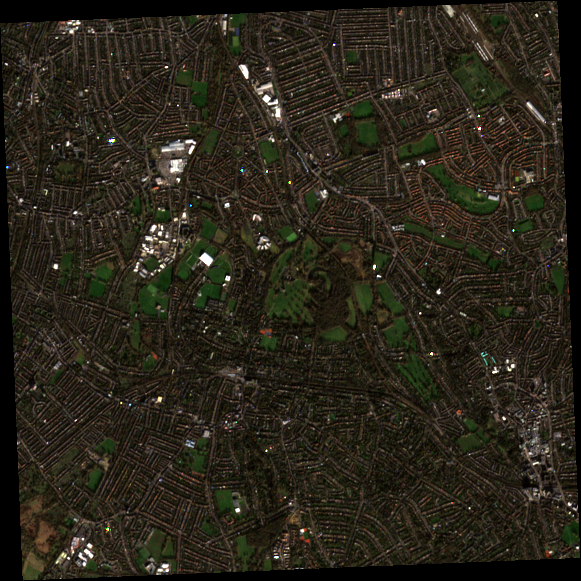

In [12]:
i = 0 # Select an example to look at from your test dataframe

image = Image.open(f'{DATA_DIR}images/' + test_df.iloc[i]['image'])

# Display the image
image

Define the prediction function

In [13]:
device = torch.device("cpu")

In [14]:
# Define the function to take in the prompt, model, and processor and return the generated text
def run_example(model, processor, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].to(device),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task = task_prompt,
        image_size=(image.width, image.height),
    )
    return parsed_answer

In [15]:
# Print out the ground truth caption (the caption from the test dataframe)
print(test_df.iloc[i]['caption'])

A good smoothness intermediate track leads to a residential area of apartments, semidetached houses, and terraces with a mix of brick, concrete, and paved surfaces. There are various amenities such as fuel stations, parking spaces, emergency access, parcel lockers, schools, a chapel, and a pub. The area also has adult gaming centers, bandstands, garden fitness stations, playgrounds, and swimming pools. There are also places of worship, restaurants, cafes, bars, and libraries, and a post office. The land has flower beds, meadows, grass, and cemeteries. The water bodies include lakes, ponds, streams, and ditches, surrounded by broadleaved trees and scrubs. The roadways include footways, pedestrian paths, cycleways, and primary and secondary links, some under construction and proposed. Railway platforms and tram tracks also pass through. There are warehouses, industrial buildings, and retail spaces, including a greenhouse. There are also carports, garages, and parking lanes, alleys, and a

In [16]:
# Model fine-tuned on natural language captions generated by GPT 3.5
task_prompt = "<CAPTION>"
run_example(nl_trained_model, nl_trained_processor, task_prompt)

{'<CAPTION>': 'A residential area with a mix of buildings including apartments, apartments, and a church. There are also various types of roads and paths, including a cycleway, footway, and cycleway. There is also a playground, sports center, and swimming pool, as well as a swimming pool and a playground. The area also includes a park, playground, and sports center. The land is mostly residential, with some commercial and industrial buildings. The water percentage is very low, and there is no snow or ice. The vegetation is medium, and the cloud cover is almost none.'}